In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline 

In [2]:
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Loading of best performing model

In [3]:
from model import Inception, get_model
from data_manipulation import IMAGE_DIM, get_image_generators

model = get_model()
model.build(input_shape=(None, IMAGE_DIM, IMAGE_DIM, 3))
model.load_weights('best_models/more_train_data-lr0.0003.h5')
train_generator, test_generator = get_image_generators({'batch_size': 1})

Found 16469 images belonging to 120 classes.
Found 4111 images belonging to 120 classes.


# Examples of augmented data

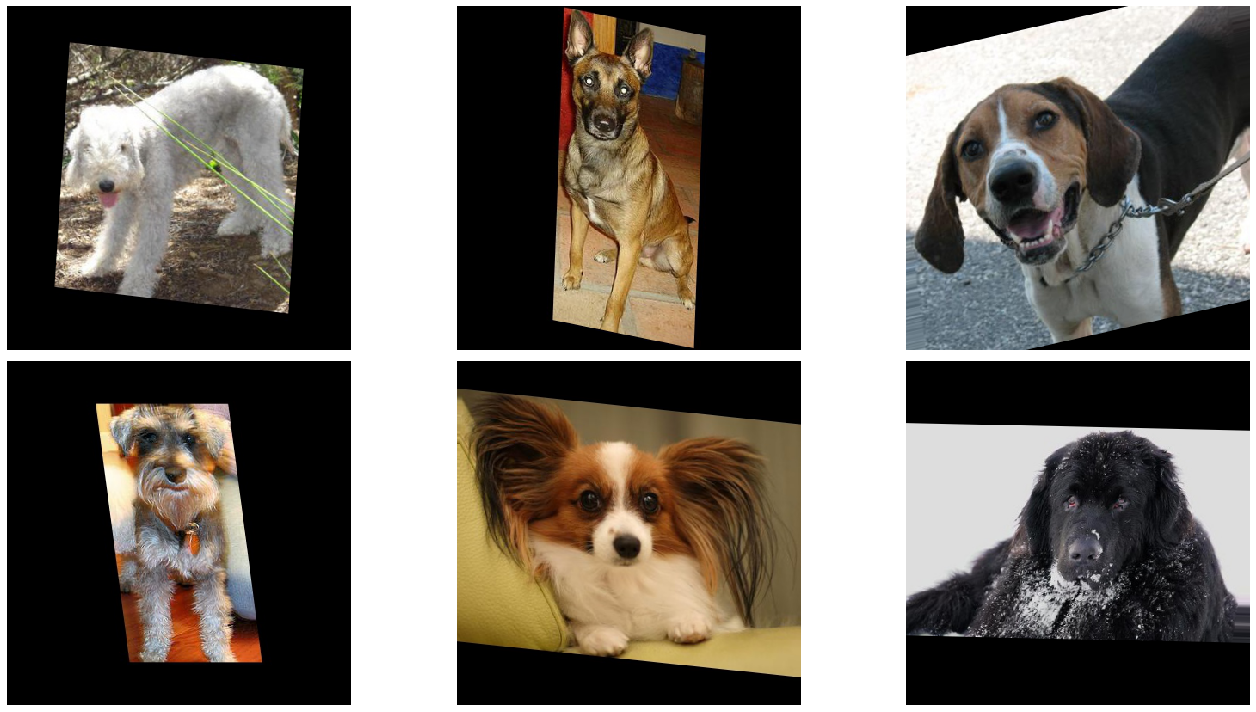

In [4]:
plt.figure(figsize=(20,10))
for i in range(6):
    plt.subplot(2,3,i+1)
    for x,y in train_generator:
        plt.imshow((x[0]))
        plt.axis('off')
        break
plt.tight_layout()
plt.show()

In [4]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_3 (Inception)      multiple                  36160     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 multiple                  0         
_________________________________________________________________
inception_4 (Inception)      multiple                  173952    
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 multiple                  0         
_________________________________________________________________
inception_5 (Inception)      multiple                  691968    
_________________________________________________________________
max_pooling2d_11 (MaxPooling multiple                  0         
_________________________________________________________________
flatten_1 (Flatten)          multiple                 

# Evaluation

In [5]:
predictions = model.predict_generator(test_generator,steps = len(test_generator.classes))

In [6]:
INDEX_TO_CLASS = {value: key for key, value in test_generator.class_indices.items()}

In [21]:
def same_order(a,b):
    if a < b:
        return a,b
    return b,a

def get_stats(labels, predictions, prediction_tries=1):
    """
    Prediction tries means how many of how many of the
    largest probabilitiest are accepted as correct prediction
    """
    CLASS_COUNT = len(predictions[0])
    correct = 0.
    class_accuracies = {class_index: 0. for class_index in range(CLASS_COUNT)}
    class_counts = {class_index: 0. for class_index in range(CLASS_COUNT)}
    class_similarities = {}
    for label, prediction in zip(labels, predictions):
        if label in prediction.argsort()[-prediction_tries:]:
            correct += 1
            class_accuracies[label] += 1
        else:
            a,b = same_order(label, prediction.argsort()[-1])
            key = f'{INDEX_TO_CLASS[a]}|{INDEX_TO_CLASS[b]}'
            if key in class_similarities:
                class_similarities[key] += 1
            else:
                class_similarities[key] = 1
        class_counts[label] += 1
    class_accuracies = {
        INDEX_TO_CLASS[class_name]: class_accuracies[class_name] / class_counts[class_name] 
        for class_name
        in class_accuracies
    }
    return correct / len(labels), class_accuracies, class_similarities

In [22]:
accuracy, class_accuracies, class_similarities = get_stats(test_generator.classes, predictions, prediction_tries=1)
print(f'Accuracy: {accuracy}')

Accuracy: 0.3634152274385794


In [23]:
two_guesses_accuracy, _, _ = get_stats(test_generator.classes, predictions, prediction_tries=2)
print(f'Two guesses accuracy: {two_guesses_accuracy}')

Two guesses accuracy: 0.5018243736317197


In [11]:
def get_top_values(value_dict, top_count=10):
    items = list(value_dict.items())
    items.sort(key=lambda t: t[1], reverse=True)
    labels = [i[0] for i in items[:top_count]]
    values = [i[1] for i in items[:top_count]]
    return labels, values

def plot_values(labels, values):
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.barh(labels[::-1], values[::-1])
    plt.xticks(rotation=90)
    plt.show()

# Most accurate classified classes

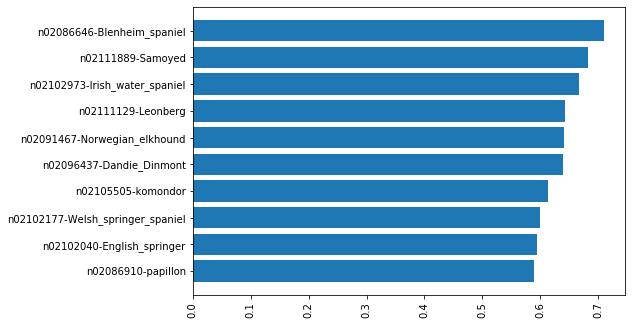

In [27]:
top_class_labels, top_class_values = get_top_values(class_accuracies)
plot_values(top_class_labels, top_class_values)

In [35]:
def get_path(class_name,image_name):
    return f'./dog_breeds_data/test/{class_name}/{image_name}'

def show_class(class_name):
    plt.figure(figsize=(20,10))
    for i in range(8):
        plt.subplot(2,4,i+1)
        image_f =os.listdir(f'./dog_breeds_data/test/{class_name}')[:8][i]
        img = load_img(get_path(class_name, image_f))
        plt.imshow(img)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

Breed name: n02086646-Blenheim_spaniel
Accuracy: 0.7105263157894737


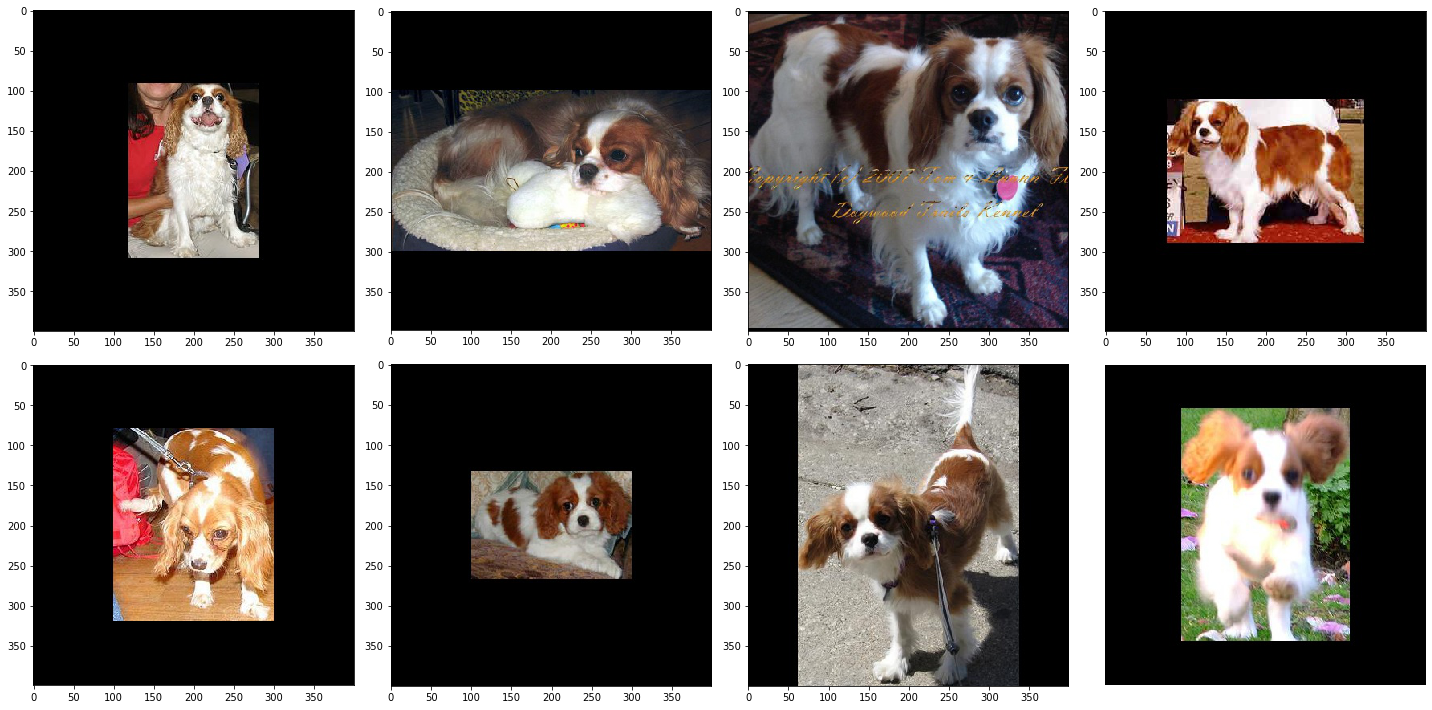

In [38]:
print(f'Breed name: {top_class_labels[0]}')
print(f'Accuracy: {class_accuracies[top_class_labels[0]]}')
show_class(top_class_labels[0])

Breed name: n02111889-Samoyed
Accuracy: 0.6818181818181818


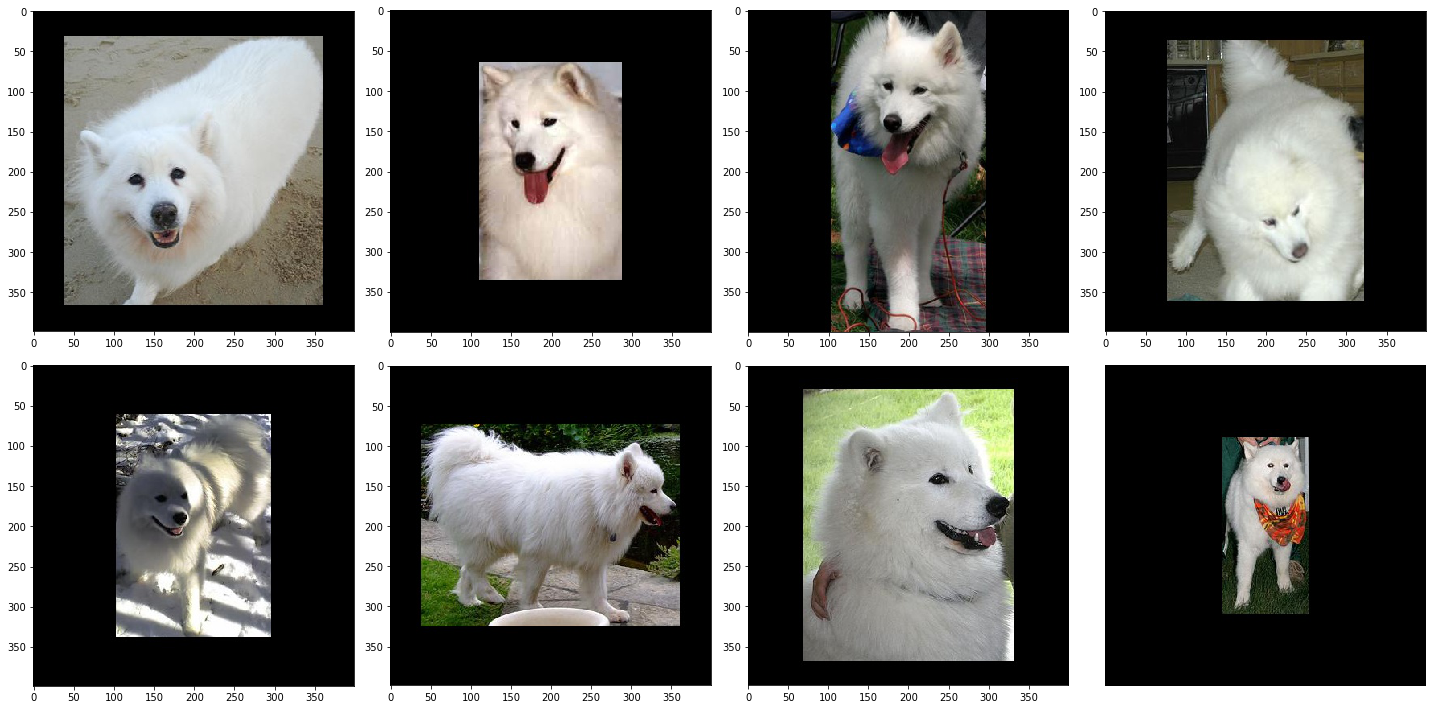

In [39]:
print(f'Breed name: {top_class_labels[1]}')
print(f'Accuracy: {class_accuracies[top_class_labels[1]]}')
show_class(top_class_labels[1])

Breed name: n02102973-Irish_water_spaniel
Accuracy: 0.6666666666666666


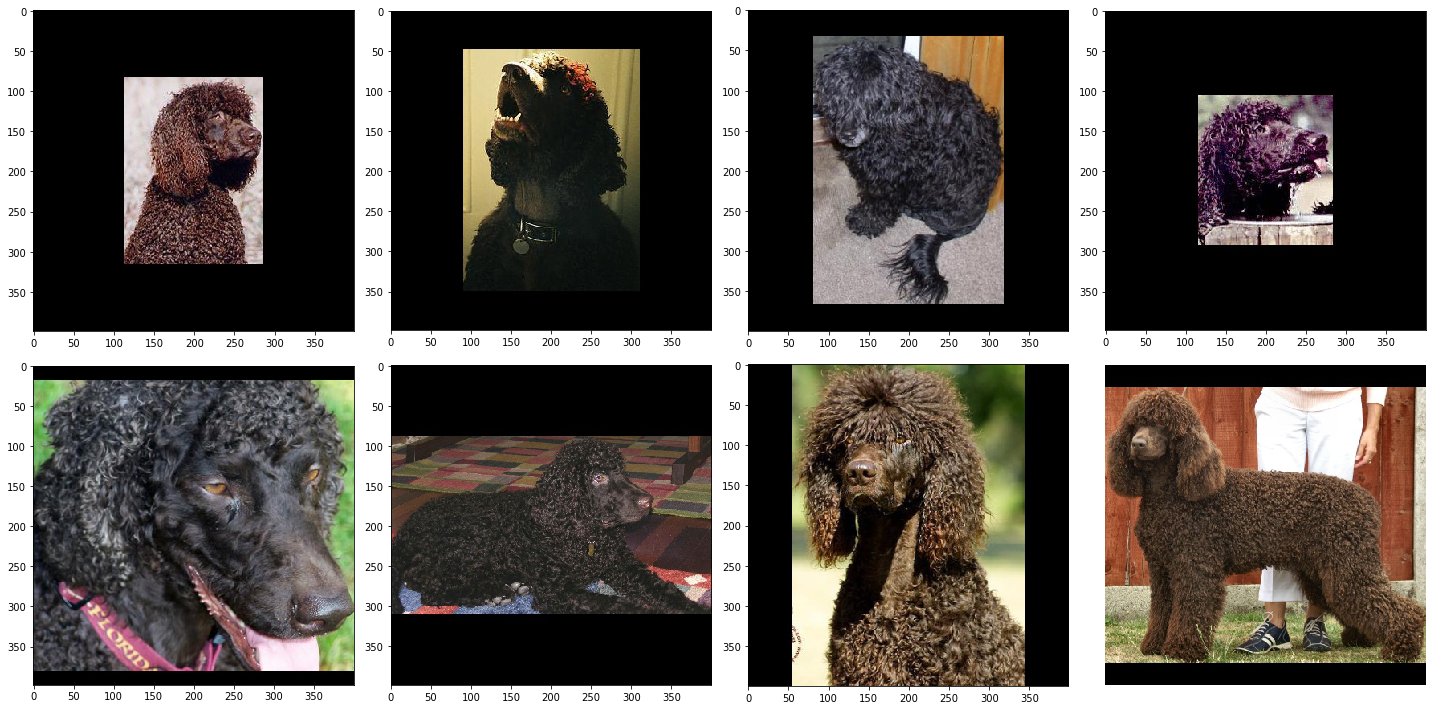

In [40]:
print(f'Breed name: {top_class_labels[2]}')
print(f'Accuracy: {class_accuracies[top_class_labels[2]]}')
show_class(top_class_labels[2])

# Most missclassified breed pairs

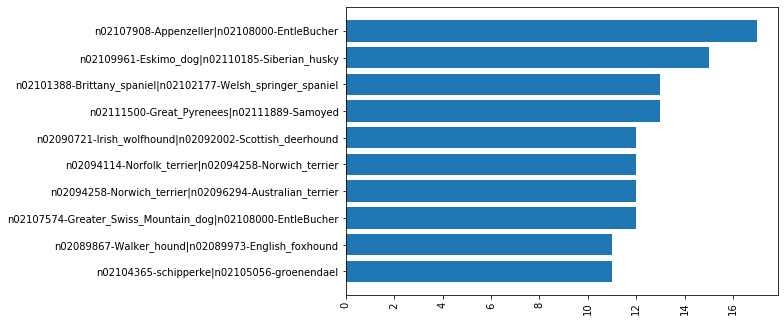

In [13]:
labels, values = get_top_values(class_similarities)
plot_values(labels, values)

In [14]:
def show_similar_classes(class1, class2):
    plt.figure(figsize=(20,10))
    for i in range(4):
        plt.subplot(2,4,i+1)
        image_f =os.listdir(f'./dog_breeds_data/test/{class1}')[:4][i]
        img = load_img(get_path(class1, image_f))
        plt.imshow(img)
    for i in range(4):
        plt.subplot(2,4,i+5)
        image_f =os.listdir(f'./dog_breeds_data/test/{class2}')[:4][i]
        img = load_img(get_path(class2, image_f))
        plt.imshow(img)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [15]:
def split_classes(classes):
    split = classes.split('|')
    return split[0], split[1]

# TOP 3 misclassified breed pairs visualized
## Top row one breed, bottom row the other

n02107908-Appenzeller in top row, n02108000-EntleBucher in bottom row


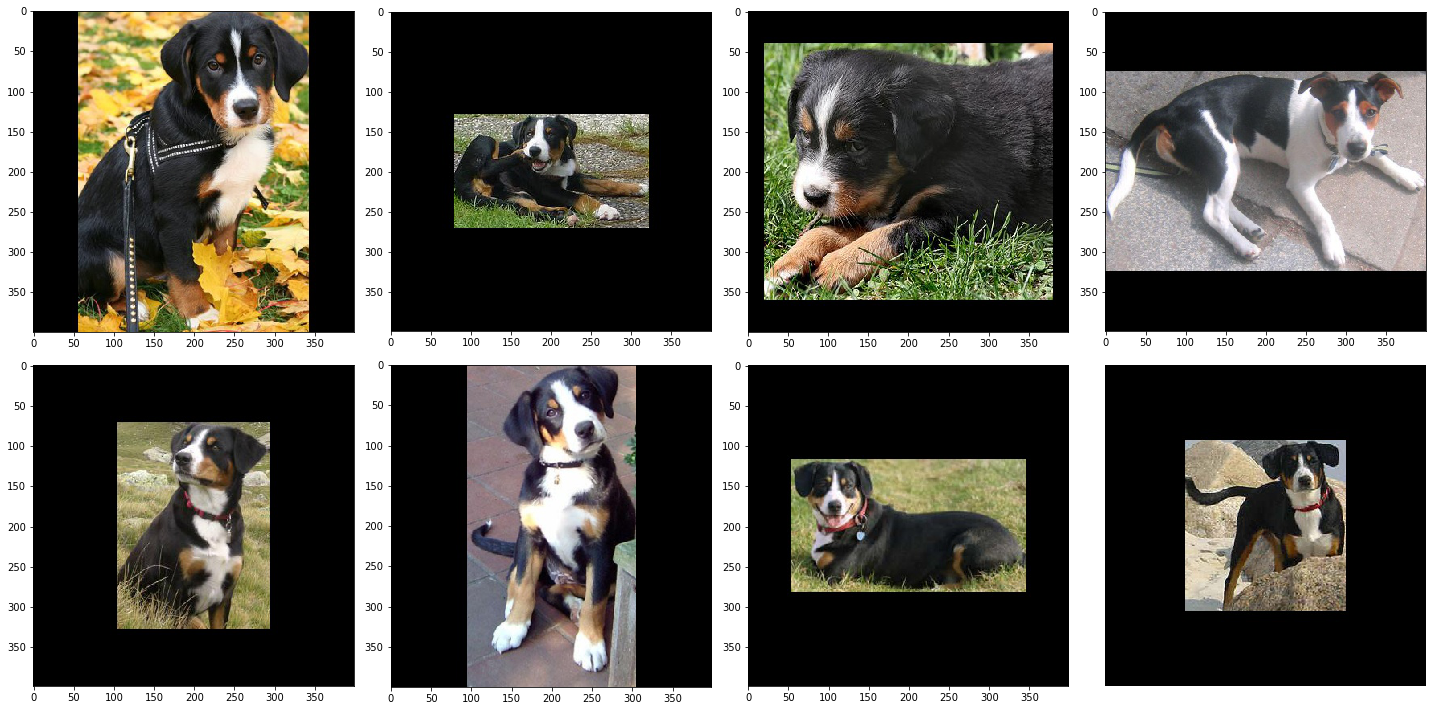

In [41]:
class1, class2 = split_classes(labels[0])
print(f'{class1} in top row, {class2} in bottom row')
show_similar_classes(class1, class2)

n02109961-Eskimo_dog in top row, n02110185-Siberian_husky in bottom row


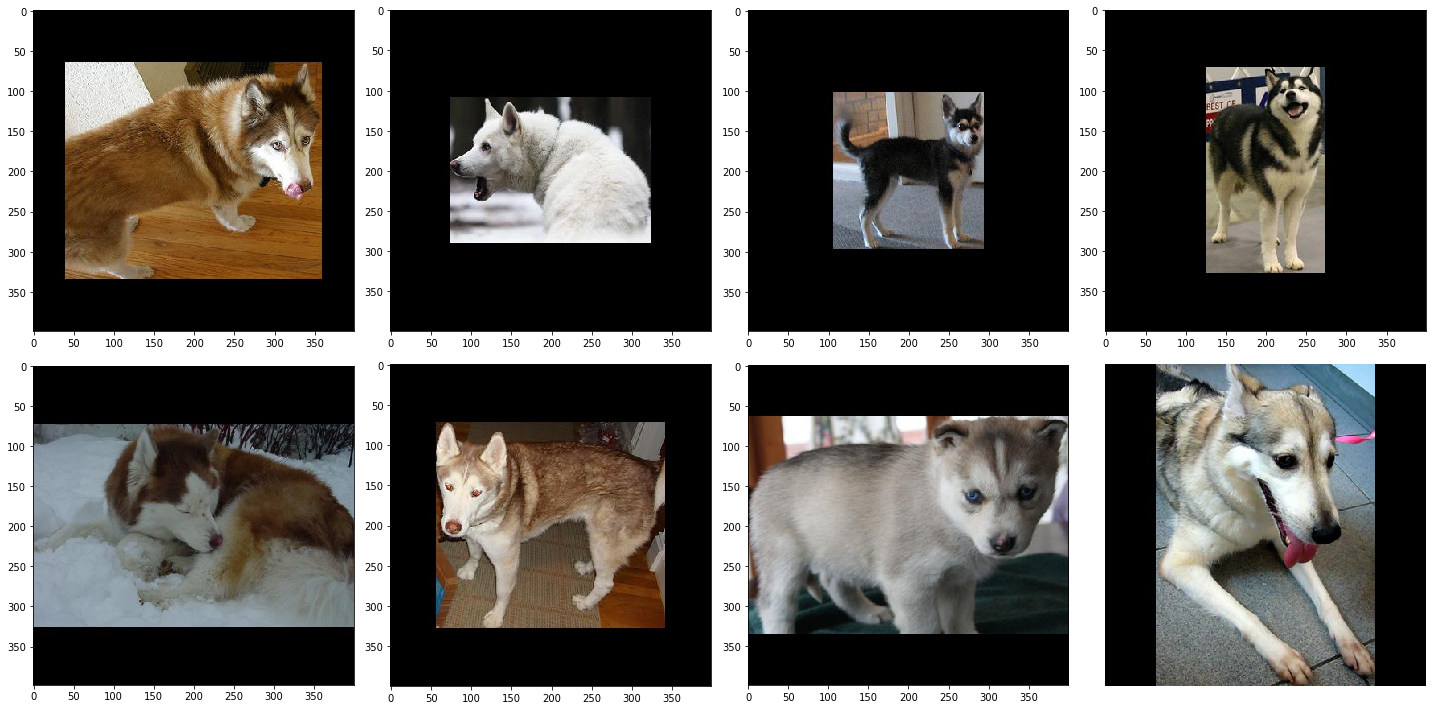

In [42]:
class1, class2 = split_classes(labels[1])
print(f'{class1} in top row, {class2} in bottom row')
show_similar_classes(class1, class2)

n02101388-Brittany_spaniel in top row, n02102177-Welsh_springer_spaniel in bottom row


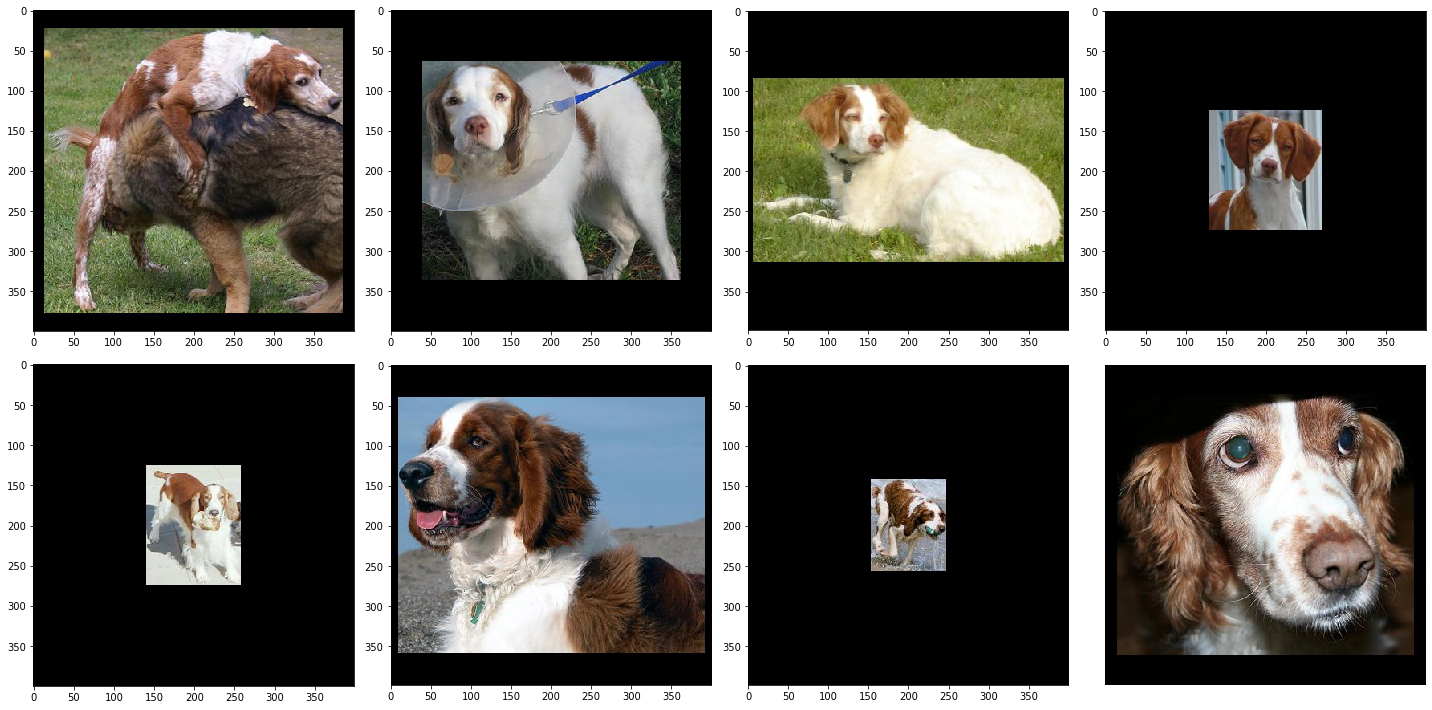

In [43]:
class1, class2 = split_classes(labels[2])
print(f'{class1} in top row, {class2} in bottom row')
show_similar_classes(class1, class2)